In [1]:
import numpy as np
import pickle
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import cherenkov_rings
reload(cherenkov_rings)

<module 'cherenkov_rings' from '/home/jpyanez/snoplus/snoplus_python/cherenkov_rings.pyc'>

In [2]:
import ROOT, rat

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


In [23]:
light_speed = 0.299792458*1000 # mm/ns

In [3]:
pmt_info = pickle.load(open('/home/jpyanez/snoplus/snoplus_python/pmt_positions.pckl'))
pmt_radii = np.linalg.norm(pmt_info['xyz'], axis=1)
costheta = pmt_info['xyz'][:,2]/pmt_radii
phi      = np.arctan2(pmt_info['xyz'][:,1], 
                      pmt_info['xyz'][:,0])


In [24]:
effective_n = 1.4

In [25]:
pmts_ring = cherenkov_rings.PMTsInRing(effective_n = effective_n)

Using cherenkov angle 44.4153085972


In [142]:
infile_name = '/home/jpyanez/snoplus/rundir/electrons_test/myelectrons.root'

In [143]:
reader = rat.dsreader(infile_name)

In [144]:
fudge = 100. #ns

Selected PMTs: 41
122.078211622


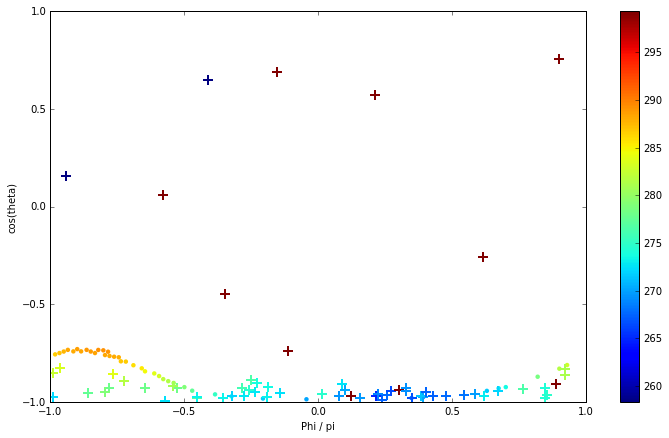

In [153]:
for ds, run in reader:
    event_bool = np.zeros_like(pmt_info['type'],dtype=bool)
    event_times = np.zeros_like(pmt_info['type'])
    
    # Assuming ONE event per trigger
    event = ds.GetEV(0)
    pmts  = event.GetCalPMTs()
    for iPMT in range(pmts.GetNormalCount()):
        one_pmt = pmts.GetPMT(iPMT)
        event_bool[int(one_pmt.GetID())]= True
        event_times[int(one_pmt.GetID())] = one_pmt.GetTime()
    
    # MC only info (or reconstruction)
    mc = ds.GetMC()
    mcev = ds.GetMCEV(0)
    particle = mc.GetMCParticle(0)
    e_dir = np.array(particle.GetMomentum())
    e_pos = np.array(particle.GetPosition())
    
    pmts_cone = pmts_ring(position = e_pos,
                      direction = e_dir)
    # Need to know the distance to calculate ToA and give them color
    pmt_vertex_distance = np.linalg.norm(pmt_info['xyz'][pmts_cone,:] - e_pos,axis=1)
    
    
    fudge = event_times[event_bool]-(particle.GetTime()+mcev.GetGTTime()+
                                     np.linalg.norm(pmt_info['xyz'][event_bool,:] - e_pos,axis=1)/(light_speed/effective_n)) 
    
    print np.median(fudge)
    
    pmt_toa = np.median(fudge) + particle.GetTime() + mcev.GetGTTime() + pmt_vertex_distance/(light_speed/effective_n)
    
    
    
    #pmt_toa = particle.GetTime() + mcev.GetGTTime() + fudge + pmt_vertex_distance/(light_speed/effective_n)

    

    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    plt.scatter(phi[pmts_cone]/np.pi, costheta[pmts_cone], 
                c = pmt_toa, cmap = 'jet',
                vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10,
                marker='o',lw = 0)

    plt.scatter(phi[event_bool]/np.pi, costheta[event_bool],
                c = event_times[event_bool], cmap = 'jet',
                vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10, s=100,
                marker='+',lw = 2)
    plt.colorbar()
    
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel('Phi / pi')
    plt.ylabel('cos(theta)')
    plt.show()
    break #raw_input()
        
#reader.close()